In [57]:
import os, shutil
train_dir = '../train'
validation_dir = '../validation'
test_dir = '../test'

In [2]:
from keras.utils import image_dataset_from_directory

IMG_SIZE = 150

train_dataset = image_dataset_from_directory(train_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))
validation_dataset = image_dataset_from_directory(validation_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))
test_dataset = image_dataset_from_directory(test_dir, label_mode='categorical', image_size=(IMG_SIZE, IMG_SIZE))

# Function to get the size of a dataset
def get_dataset_size(dataset):
    return sum(1 for _ in dataset)

# Calculate the original sizes of the datasets
train_size = get_dataset_size(train_dataset)
validation_size = get_dataset_size(validation_dataset)
test_size = get_dataset_size(test_dataset)

# Calculate the size of each part
part_train_size = train_size // 4
part_validation_size = validation_size // 4
part_test_size = test_size // 4

# Function to create subsets of the datasets
def split_dataset(dataset, part_size):
    parts = []
    for i in range(4):
        parts.append(dataset.skip(i * part_size).take(part_size))
    return parts

# Create the subsets for each dataset
train_parts = split_dataset(train_dataset, part_train_size)
validation_parts = split_dataset(validation_dataset, part_validation_size)
test_parts = split_dataset(test_dataset, part_test_size)

# Assign the subsets to separate variables
train_dataset_1, train_dataset_2, train_dataset_3, train_dataset_4 = train_parts
validation_dataset_1, validation_dataset_2, validation_dataset_3, validation_dataset_4 = validation_parts
test_dataset_1, test_dataset_2, test_dataset_3, test_dataset_4 = test_parts

# Print the sizes of the subsets
print(f"Train dataset parts sizes: {[get_dataset_size(part) for part in train_parts]}")
print(f"Validation dataset parts sizes: {[get_dataset_size(part) for part in validation_parts]}")
print(f"Test dataset parts sizes: {[get_dataset_size(part) for part in test_parts]}")


2024-05-30 17:20:28.817722: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 40000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Train dataset parts sizes: [312, 312, 312, 312]
Validation dataset parts sizes: [78, 78, 78, 78]
Test dataset parts sizes: [78, 78, 78, 78]


In [3]:
#import ssl
#import requests

#requests.packages.urllib3.disable_warnings()
#ssl._create_default_https_context = ssl._create_unverified_context
#response = requests.get('https://storage.googleapis.com/tensorflow/keras-applications/vgg19/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

from tensorflow.keras.applications.vgg19 import VGG19

conv_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
conv_base.trainable = False

In [4]:
from tensorflow import keras 
import numpy as np

def get_features_and_labels(dataset): 
    all_features = []
    all_labels = []

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg19.preprocess_input(images) 
        features = conv_base.predict(preprocessed_images) 
        all_features.append(features)
        all_labels.append(labels)

    return np.concatenate(all_features), np.concatenate(all_labels)

In [8]:
#Dividimos o dataset em quatro partes
#1/4
train_features_1, train_labels_1 = get_features_and_labels(train_dataset_1)
val_features_1, val_labels_1 = get_features_and_labels(validation_dataset_1)
#test_features_1, test_labels_1 = get_features_and_labels(test_dataset_1)

#2/4
#train_features_2, train_labels_2 = get_features_and_labels(train_dataset_2)
#val_features_2, val_labels_2 = get_features_and_labels(validation_dataset_2)
#test_features_2, test_labels_2 = get_features_and_labels(test_dataset_2)

#3/4
#train_features_3, train_labels_3 = get_features_and_labels(train_dataset_3)
#val_features_3, val_labels_3 = get_features_and_labels(validation_dataset_3)
#test_features_3, test_labels_3 = get_features_and_labels(test_dataset_3)

#4/4
#train_features_4, train_labels_4 = get_features_and_labels(train_dataset_4)
#val_features_4, val_labels_4 = get_features_and_labels(validation_dataset_4)
#test_features_4, test_labels_4 = get_features_and_labels(test_dataset_4)


1/1 [==============================] - 2s 2s/step


In [9]:
conv_base.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [10]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.regularizers import l2

inputs = keras.Input(shape=(4, 4, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(10, activation="softmax")(x)

model = keras.Model(inputs, outputs)

In [11]:
#A partir deste bloco iremos treinar o modelo para os sub datasets
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=1e-4),metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=80, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

In [12]:
history = model.fit(train_features_1, train_labels_1,epochs=40, batch_size=32, validation_data=(val_features_1, val_labels_1),callbacks=[early_stopping])

Epoch 1/40
312/312 [==============================] - 11s 31ms/step - loss: 3.5835 - accuracy: 0.2961 - val_loss: 2.0714 - val_accuracy: 0.6266
Epoch 2/40
312/312 [==============================] - 11s 34ms/step - loss: 2.4064 - accuracy: 0.5543 - val_loss: 1.7692 - val_accuracy: 0.7392
Epoch 3/40
312/312 [==============================] - 10s 32ms/step - loss: 2.0408 - accuracy: 0.6582 - val_loss: 1.6543 - val_accuracy: 0.7676
Epoch 4/40
312/312 [==============================] - 10s 33ms/step - loss: 1.8539 - accuracy: 0.7173 - val_loss: 1.5907 - val_accuracy: 0.7869
Epoch 5/40
312/312 [==============================] - 11s 36ms/step - loss: 1.7213 - accuracy: 0.7548 - val_loss: 1.5475 - val_accuracy: 0.8013
Epoch 6/40
312/312 [==============================] - 10s 33ms/step - loss: 1.6353 - accuracy: 0.7789 - val_loss: 1.5186 - val_accuracy: 0.8121
Epoch 7/40
312/312 [==============================] - 10s 33ms/step - loss: 1.5754 - accuracy: 0.7952 - val_loss: 1.4923 - val_accuracy:

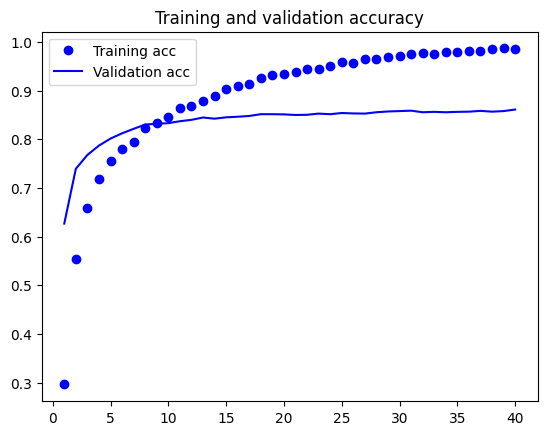

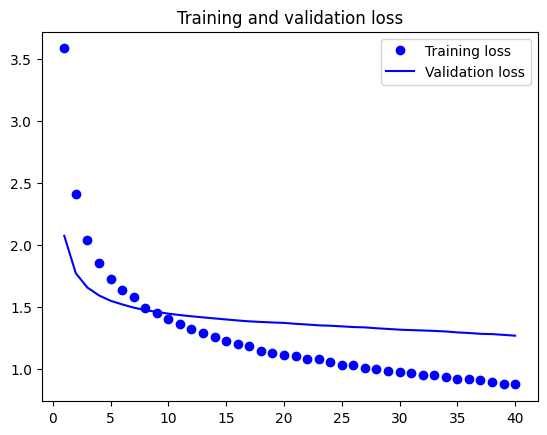

In [13]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc,'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss,'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [14]:
#Get features dataset 2/4
train_features_2, train_labels_2 = get_features_and_labels(train_dataset_2)
val_features_2, val_labels_2 = get_features_and_labels(validation_dataset_2)
#test_features_2, test_labels_2 = get_features_and_labels(test_dataset_2)

1/1 [==============================] - 2s 2s/step


In [15]:
history = model.fit(train_features_2, train_labels_2,epochs=40, batch_size=32, validation_data=(val_features_2, val_labels_2),callbacks=[early_stopping])

Epoch 1/40
312/312 [==============================] - 11s 35ms/step - loss: 1.4214 - accuracy: 0.8273 - val_loss: 1.2157 - val_accuracy: 0.8698
Epoch 2/40
312/312 [==============================] - 11s 35ms/step - loss: 1.2925 - accuracy: 0.8511 - val_loss: 1.2046 - val_accuracy: 0.8698
Epoch 3/40
312/312 [==============================] - 11s 36ms/step - loss: 1.2061 - accuracy: 0.8730 - val_loss: 1.1964 - val_accuracy: 0.8714
Epoch 4/40
312/312 [==============================] - 11s 34ms/step - loss: 1.1597 - accuracy: 0.8824 - val_loss: 1.1911 - val_accuracy: 0.8766
Epoch 5/40
312/312 [==============================] - 11s 36ms/step - loss: 1.1337 - accuracy: 0.8923 - val_loss: 1.1847 - val_accuracy: 0.8766
Epoch 6/40
312/312 [==============================] - 11s 35ms/step - loss: 1.0856 - accuracy: 0.9027 - val_loss: 1.1798 - val_accuracy: 0.8738
Epoch 7/40
312/312 [==============================] - 11s 36ms/step - loss: 1.0588 - accuracy: 0.9086 - val_loss: 1.1744 - val_accuracy:

In [16]:
#Get features dataset 3/4
train_features_3, train_labels_3 = get_features_and_labels(train_dataset_3)
val_features_3, val_labels_3 = get_features_and_labels(validation_dataset_3)
#test_features_3, test_labels_3 = get_features_and_labels(test_dataset_3)

1/1 [==============================] - 3s 3s/step


In [17]:
history = model.fit(train_features_3, train_labels_3,epochs=80, batch_size=32, validation_data=(val_features_3, val_labels_3),callbacks=[early_stopping])

Epoch 1/80
312/312 [==============================] - 11s 34ms/step - loss: 1.2513 - accuracy: 0.8435 - val_loss: 1.0626 - val_accuracy: 0.8814
Epoch 2/80
312/312 [==============================] - 10s 32ms/step - loss: 1.0834 - accuracy: 0.8703 - val_loss: 1.0528 - val_accuracy: 0.8834
Epoch 3/80
312/312 [==============================] - 10s 33ms/step - loss: 1.0351 - accuracy: 0.8833 - val_loss: 1.0476 - val_accuracy: 0.8818
Epoch 4/80
312/312 [==============================] - 11s 34ms/step - loss: 0.9743 - accuracy: 0.8958 - val_loss: 1.0435 - val_accuracy: 0.8834
Epoch 5/80
312/312 [==============================] - 10s 32ms/step - loss: 0.9286 - accuracy: 0.9044 - val_loss: 1.0417 - val_accuracy: 0.8798
Epoch 6/80
312/312 [==============================] - 10s 31ms/step - loss: 0.8955 - accuracy: 0.9150 - val_loss: 1.0406 - val_accuracy: 0.8826
Epoch 7/80
312/312 [==============================] - 10s 31ms/step - loss: 0.8628 - accuracy: 0.9249 - val_loss: 1.0371 - val_accuracy:

In [19]:
train_features_4, train_labels_4 = get_features_and_labels(train_dataset_4)
val_features_4, val_labels_4 = get_features_and_labels(validation_dataset_4)
#test_features_4, test_labels_4 = get_features_and_labels(test_dataset_4)

1/1 [==============================] - 2s 2s/step


In [21]:
#Baixamos o lerning rate para tentar chegar aos 0.9 de val_accuracy
#Adicionamos os weight_decay para regolarização, também para combater o overfiting
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=1e-4),metrics=['accuracy'])

history = model.fit(train_features_4, train_labels_4,epochs=120, batch_size=32, validation_data=(val_features_4, val_labels_4),callbacks=[early_stopping])

Epoch 1/120
312/312 [==============================] - 10s 31ms/step - loss: 0.4956 - accuracy: 0.9323 - val_loss: 0.6983 - val_accuracy: 0.8938
Epoch 2/120
312/312 [==============================] - 9s 30ms/step - loss: 0.4980 - accuracy: 0.9317 - val_loss: 0.6971 - val_accuracy: 0.8922
Epoch 3/120
312/312 [==============================] - 10s 31ms/step - loss: 0.4916 - accuracy: 0.9353 - val_loss: 0.6955 - val_accuracy: 0.8930
Epoch 4/120
312/312 [==============================] - 10s 31ms/step - loss: 0.4866 - accuracy: 0.9402 - val_loss: 0.6965 - val_accuracy: 0.8934
Epoch 5/120
312/312 [==============================] - 10s 31ms/step - loss: 0.4755 - accuracy: 0.9406 - val_loss: 0.6965 - val_accuracy: 0.8922
Epoch 6/120
312/312 [==============================] - 10s 31ms/step - loss: 0.4841 - accuracy: 0.9354 - val_loss: 0.6953 - val_accuracy: 0.8934
Epoch 7/120
312/312 [==============================] - 10s 31ms/step - loss: 0.4709 - accuracy: 0.9416 - val_loss: 0.6950 - val_acc

In [28]:
#Guardar o modelo
from keras import models
inputs = keras.Input(shape=(150, 150, 3))
x = keras.applications.vgg19.preprocess_input(inputs) 
x = conv_base(x)
outputs = model(x)
full_model = keras.Model(inputs, outputs)

full_model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=1e-4),metrics=['accuracy'])

In [29]:
full_model.save('ModelT_transferLearning_featureExtraction_WithoutDataAumentation.h5')
model.save('ModelT_transferLearning_featureExtraction_WithoutDataAumentation_OnlyClassification.h5')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
#tentar chegar a 0.9 de vall_acc
early_stopping = EarlyStopping(monitor='val_loss', patience=120, restore_best_weights=True)

model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-6, weight_decay=1e-3),metrics=['accuracy'])

history = model.fit(train_features_1, train_labels_1,epochs=120, batch_size=32, validation_data=(val_features_1, val_labels_1), callbacks=[early_stopping])

Epoch 1/120
312/312 [==============================] - 11s 32ms/step - loss: 7.5088 - accuracy: 0.5365 - val_loss: 7.3419 - val_accuracy: 0.6206
Epoch 2/120
312/312 [==============================] - 10s 33ms/step - loss: 7.4937 - accuracy: 0.5378 - val_loss: 7.3027 - val_accuracy: 0.6234
Epoch 3/120
 87/312 [=======>......................] - ETA: 7s - loss: 7.4733 - accuracy: 0.5456

KeyboardInterrupt: 

In [58]:
from tensorflow import keras

loaded_model = keras.models.load_model('ModelT_transferLearning_featureExtraction_WithoutDataAumentation.h5')

val_loss, val_acc = loaded_model.evaluate(test_dataset) 
print('val_acc:', val_acc)

313/313 [==============================] - 789s 3s/step - loss: 0.7017 - accuracy: 0.8878
val_acc: 0.8877999782562256
